# In this notebook I build a forecasting LSTM model to predict the weather. The data is downloaded from https://www.ncdc.noaa.gov/cdo-web/.

In [1]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Inspect the data
raw_data = pd.read_csv('metric_data.csv', index_col='DATE')
raw_data.index = pd.to_datetime(raw_data.index)
raw_data

,STATION,NAME,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,PGTM,...,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT16,WT18
DATE,,,,,,,,,,,,,,,,,,,,,
1950-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1950-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1950-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
1950-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check for NaNs in the data. I just remove columns wher more than half the values are NaNs.

In [3]:
# Find the fraction of NaN values in each column
NaN_fraction = raw_data.isna().mean()
good_columns = NaN_fraction[NaN_fraction < 0.5].index
# Select only the columns with < 50% NaN values
df_selected = raw_data[good_columns]
df_selected

,STATION,NAME,PRCP,SNOW,SNWD,TMAX,TMIN
DATE,,,,,,,
1950-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",0.0,0.0,0.0,10.6,1.7
1950-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",4.1,0.0,0.0,8.9,2.2
1950-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",0.0,0.0,0.0,8.3,-1.7
1950-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",0.0,0.0,0.0,6.7,-2.8
1950-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",0.0,0.0,0.0,10.0,-2.8
...,...,...,...,...,...,...,...
2024-03-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",11.9,NaN,NaN,14.4,10.0
2024-03-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",8.9,NaN,NaN,12.8,7.2
2024-03-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",9.9,NaN,NaN,12.2,7.2


The columns left are "Precipitation", "Snowfall", "Snow depth", "TMAX max", "TMAX min".

In [4]:
print(df_selected['SNOW'].value_counts())
print(df_selected['SNWD'].value_counts())
print(df_selected['STATION'].value_counts())
print(df_selected['NAME'].value_counts())

SNOW
0.0     15031
25.0        1
Name: count, dtype: int64
SNWD
0.0    15155
Name: count, dtype: int64
STATION
USW00023230    21279
Name: count, dtype: int64
NAME
OAKLAND INTERNATIONAL AIRPORT, CA US    21279
Name: count, dtype: int64


These columns only contain one value (except for snow where there is only one instance of snow, which is not enough for the model to learn from). Therefore, I will drop these columns. 

In [5]:
df = df_selected[['PRCP', 'TMAX', 'TMIN']]

In [6]:
df['PRCP'].isna().sum()/len(df)

0.013346491846421355

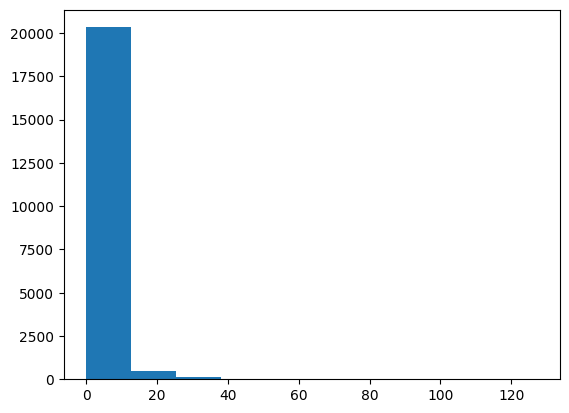

In [7]:
plt.hist(df['PRCP']);

1.3% of the precipitation data is missing. I will fill these with the most common value, which is 0 by far. The few NaNs in the temperature columns are just dropped.

In [8]:
df['PRCP'].fillna(0, inplace=True)
df.dropna(inplace=True)

C:\Users\simon\AppData\Local\Temp\ipykernel_25816\3915466754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRCP'].fillna(0, inplace=True)
C:\Users\simon\AppData\Local\Temp\ipykernel_25816\3915466754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


<Axes: xlabel='DATE'>

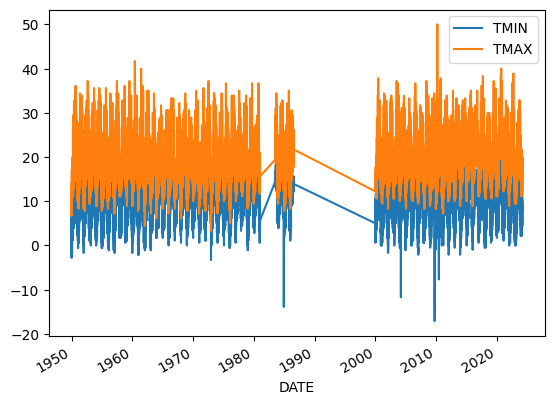

In [9]:
df[['TMIN','TMAX']].plot()

Text(0.5, 1.0, 'Total Precipitation per Year')

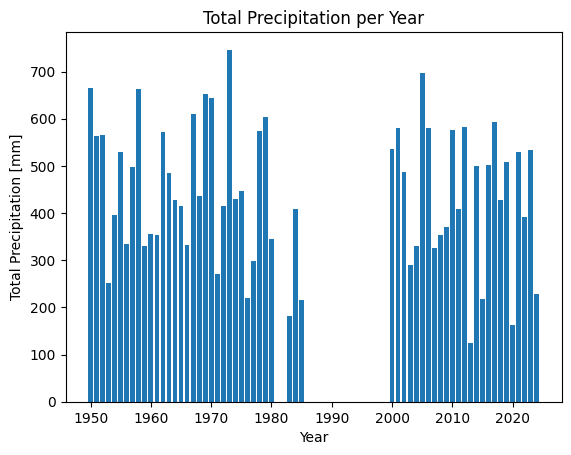

In [10]:
df.index = pd.to_datetime(df.index)
plt.bar(df.index.year.unique(), df.groupby(df.index.year)['PRCP'].sum())
plt.xlabel('Year')
plt.ylabel('Total Precipitation [mm]')
plt.title('Total Precipitation per Year')

In [11]:
# Split data into before and after 2015
split_date = '2015-01-01'
train_data = df.loc['1950-01-01':split_date]
test_data = df.loc[split_date:'2024-01-01']

# Prepare the data
train_values = train_data[['PRCP', 'TMAX', 'TMIN']].values
test_values = test_data[['PRCP', 'TMAX', 'TMIN']].values

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Define a function to create the LSTM dataset
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

# Set time steps (number of previous time steps to use for prediction)
time_steps = 12  # Example: Using the previous 12 time steps to predict the next one

# Create the LSTM dataset for training
X_train, y_train = create_dataset(train_scaled, time_steps)

# Reshape input data to be 3D (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

X_test, y_test = create_dataset(test_scaled, time_steps)

# Reshape input data to be 3D (samples, time steps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


C:\Users\simon\AppData\Local\Temp\ipykernel_25816\3376311353.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(inplace=True)
C:\Users\simon\AppData\Local\Temp\ipykernel_25816\3376311353.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.dropna(inplace=True)


In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) #(12,3)
model.add(LSTM(units=50))
model.add(Dense(units=3))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
560/560 [==============================] - 11s 10ms/step - loss: 0.0050
Epoch 2/100
560/560 [==============================] - 5s 9ms/step - loss: 0.0032
Epoch 3/100
560/560 [==============================] - 5s 9ms/step - loss: 0.0028
Epoch 4/100
560/560 [==============================] - 5s 8ms/step - loss: 0.0025
Epoch 5/100
560/560 [==============================] - 5s 8ms/step - loss: 0.0024
Epoch 6/100
560/560 [==============================] - 5s 8ms/step - loss: 0.0024
Epoch 7/100
560/560 [==============================] - 5s 8ms/step - loss: 0.0024
Epoch 8/100
560/560 [==============================] - 5s 9ms/step - loss: 0.0023
Epoch 9/100
560/560 [==============================] - 5s 9ms/step - loss: 0.0023
Epoch 10/100
560/560 [==============================] - 5s 9ms/step - loss: 0.0023
Epoch 11/100
560/560 [==============================] - 5s 8ms/step - loss: 0.0023
Epoch 12/100
560/560 [==============================] - 5s 8ms/step - loss: 0.0023
Epoch 13/10

Now we make predictions on the test data.

In [13]:
test_predictions = model.predict(X_test)
# We have to inverse the scaling to get the real predictions
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

103/103 [==============================] - 1s 4ms/step


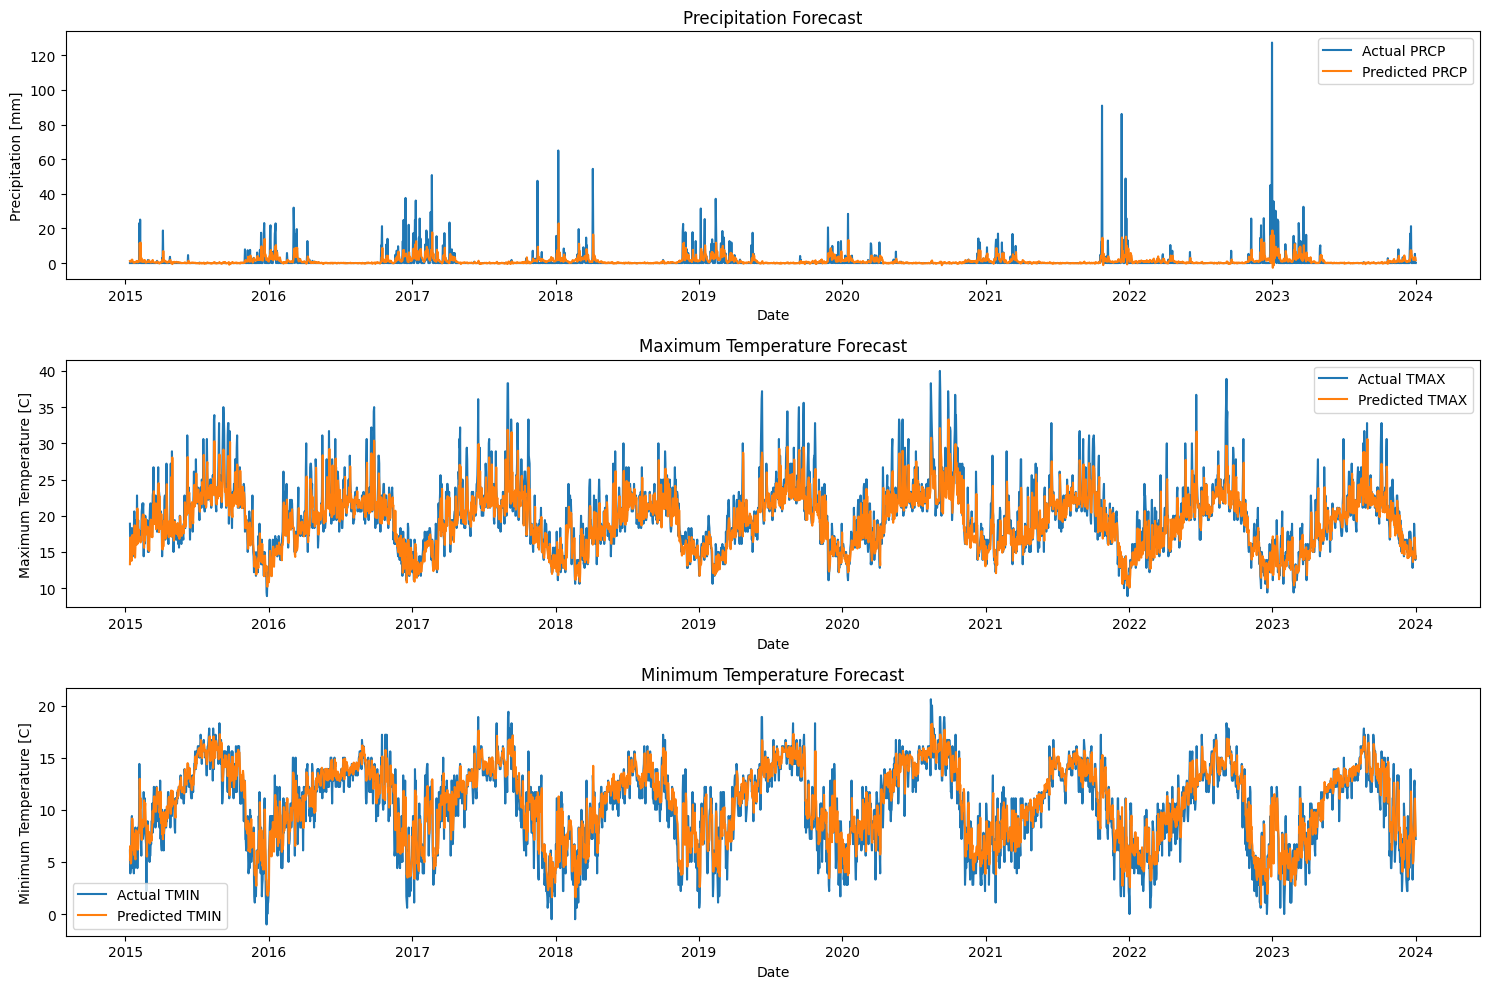

In [15]:
plt.figure(figsize=(15, 10))

# Plotting PRCP
plt.subplot(3, 1, 1)
plt.plot(test_data.index[time_steps:], y_test[:, 0], label='Actual PRCP')
plt.plot(test_data.index[time_steps:], test_predictions[:, 0], label='Predicted PRCP')
plt.xlabel('Date')
plt.ylabel('Precipitation [mm]')
plt.title('Precipitation Forecast')
plt.legend()

# Plotting TMAX
plt.subplot(3, 1, 2)
plt.plot(test_data.index[time_steps:], y_test[:, 1], label='Actual TMAX')
plt.plot(test_data.index[time_steps:], test_predictions[:, 1], label='Predicted TMAX')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature [C]')
plt.title('Maximum Temperature Forecast')
plt.legend()

# Plotting TMIN
plt.subplot(3, 1, 3)
plt.plot(test_data.index[time_steps:], y_test[:, 2], label='Actual TMIN')
plt.plot(test_data.index[time_steps:], test_predictions[:, 2], label='Predicted TMIN')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature [C]')
plt.title('Minimum Temperature Forecast')
plt.legend()

plt.tight_layout()
plt.show()